# 레드 와인 품질 분류 분석 + 탐색적 데이터 분석

## 1. Overview

입력 변수 : fixed acidity, volatile acidity, citric acid, residual suger, chlorides,
          free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol

출력 변수 : quality (0과 10 사이 값으로 구성됨)

# 2. Importing Libraries and Reading the Dataset

여러 라이브러리를 가져오고 레드 와인 품질에 관한 csv 파일을 읽어온다.

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from collections import Counter
sns.set_style('darkgrid')

In [30]:
dataset = pd.read_csv('winequality-red.csv')
dataset.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## 3. Data Visualization and Preprocessing

데이터 시각화 및 전처리 단계를 거친다.

In [31]:
dataset.isnull().sum() #null값이 몇 개 있는지 확인

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

'quality' column의 값을 'bad' 또는 'good'의 범주 값으로 변환한다.

In [32]:
bins = (2, 6.5, 8)
labels = ['bad', 'good']
dataset['quality'] = pd.cut(x = dataset['quality'], bins = bins, labels = labels)

bad와 good 데이터가 각각 몇개 있는지 확인해본다.

In [33]:
dataset['quality'].value_counts()

bad     1382
good     217
Name: quality, dtype: int64

quality column의 문자열 라벨을 숫자로 인코딩한다.

In [34]:
from sklearn.preprocessing import LabelEncoder
labelencoder_y = LabelEncoder()
dataset['quality'] = labelencoder_y.fit_transform(dataset['quality'])

In [35]:
dataset.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


데이터셋의 상관계수를 히트맵으로 시각화하여 보여준다.

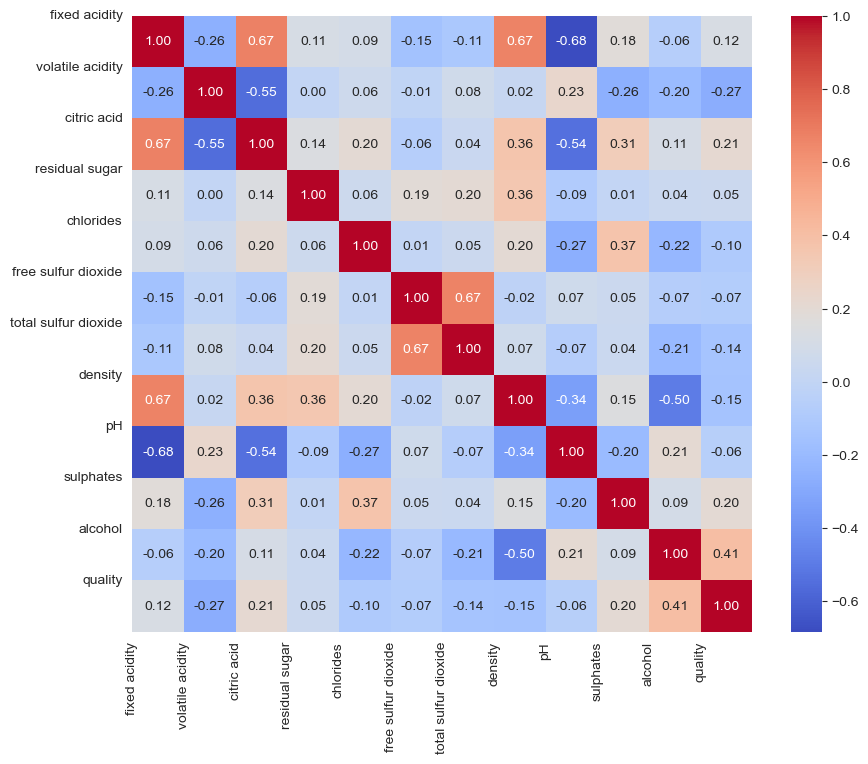

In [36]:
corr = dataset.corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(10, 8))
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")
#Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns)
#Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
#show plot
plt.show()

In [37]:
dataset['quality'].value_counts()

0    1382
1     217
Name: quality, dtype: int64

전처리 과정

X는 quality column을 뺀 모든 column 데이터가 됨 (피처값)
y는 quality column 데이터가 됨 (타겟값)

train_test_split을 통해 훈련 데이터 세트와 테스트 데이터 세트로 나눈다.

In [38]:
X = dataset.drop('quality', axis=1).values
y = dataset['quality'].values.reshape(-1,1)

In [39]:
#훈련 데이터 세트와 테스트 데이터 세트로 나눈다.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (1279, 11)
Shape of X_test:  (320, 11)
Shape of y_train:  (1279, 1)
Shape of y_test (320, 1)


## 4. Classification Models

분류 모델 적용에 앞서 피처값을 표준화한다.(각 피처의 평균을 0으로, 표준편차를 1로 만들어 줌)

fit_transform()으로 훈련 데이터의 스케일링을 수행
transform()으로 테스트 데이터의 스케일링을 수행

In [41]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

##### Logistic Regression

스케일링된 훈련 데이터에 로지스틱 회귀 모델을 적합시키는 과정

사이킷런 LogisticRegression 클래스 사용

하이퍼 파라미터를 살펴보면 C=1 : 규제의 강도가 약함, 최대 반복 횟수는 1000번, L2 규제를 씀

In [42]:
# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier_lr = LogisticRegression(C=1, fit_intercept=True, max_iter=1000, penalty = 'l2', solver='liblinear')
classifier_lr.fit(X_train_scaled, y_train.ravel())

LogisticRegression(C=1, max_iter=1000, solver='liblinear')

cross_val_score() : 교차 검증 수행 및 성능 평가 (여기서는 10-Fold CV)

predict를 통해 훈련 데이터 예측하고 accuracy_score를 통해 정확도 측정 및 출력

predict를 통해 테스트 데이터 예측하고 accuracy_score를 통해 정확도 측정 및 출력

In [43]:
# Predicting Cross Validation Score
cv_lr = cross_val_score(estimator = classifier_lr, X = X_train_scaled, y = y_train.ravel(), cv = 10)
print("CV: ", cv_lr.mean()) #교차 검증 평균 성능 출력

y_pred_lr_train = classifier_lr.predict(X_train_scaled)
accuracy_lr_train = accuracy_score(y_train, y_pred_lr_train)
print("Training set: ", accuracy_lr_train)

y_pred_lr_test = classifier_lr.predict(X_test_scaled)
accuracy_lr_test = accuracy_score(y_test, y_pred_lr_test)
print("Test set: ", accuracy_lr_test)

CV:  0.885857529527559
Training set:  0.8858483189992181
Test set:  0.865625


In [44]:
confusion_matrix(y_test, y_pred_lr_test) #confusion matrix 생성

array([[264,   9],
       [ 34,  13]])

In [45]:
#confusion matrix 각 요소를 새로운 변수에 저장
tp_lr = confusion_matrix(y_test, y_pred_lr_test)[0,0]
fp_lr = confusion_matrix(y_test, y_pred_lr_test)[0,1]
tn_lr = confusion_matrix(y_test, y_pred_lr_test)[1,1]
fn_lr = confusion_matrix(y_test, y_pred_lr_test)[1,0]

##### K-Nearest Neighbors (K-NN) 

In [46]:
# Fitting classifier to the Training set
from sklearn.neighbors import KNeighborsClassifier
classifier_knn = KNeighborsClassifier(leaf_size = 1, metric = 'minkowski', n_neighbors = 32, weights = 'distance')
classifier_knn.fit(X_train_scaled, y_train.ravel())

KNeighborsClassifier(leaf_size=1, n_neighbors=32, weights='distance')

In [47]:
# Predicting Cross Validation Score
cv_knn = cross_val_score(estimator = classifier_knn, X = X_train_scaled, y = y_train.ravel(), cv = 10)
print("CV: ", cv_knn.mean())

y_pred_knn_train = classifier_knn.predict(X_train_scaled)
accuracy_knn_train = accuracy_score(y_train, y_pred_knn_train)
print("Training set: ", accuracy_knn_train)

y_pred_knn_test = classifier_knn.predict(X_test_scaled)
accuracy_knn_test = accuracy_score(y_test, y_pred_knn_test)
print("Test set: ", accuracy_knn_test)

CV:  0.9022699311023622
Training set:  1.0
Test set:  0.89375


In [48]:
confusion_matrix(y_test, y_pred_knn_test)

array([[264,   9],
       [ 25,  22]])

In [49]:
tp_knn = confusion_matrix(y_test, y_pred_knn_test)[0,0]
fp_knn = confusion_matrix(y_test, y_pred_knn_test)[0,1]
tn_knn = confusion_matrix(y_test, y_pred_knn_test)[1,1]
fn_knn = confusion_matrix(y_test, y_pred_knn_test)[1,0]

##### Support Vector Machine (SVM - Linear)

선형 서포트 벡터 머신 모델을 훈련 데이터에 적합시키는 과정

교차 검증을 수행하고 훈련 데이터와 검증 데이터를 예측하며 정확도를 출력한다.

In [50]:
# Fitting classifier to the Training set
from sklearn.svm import SVC
classifier_svm_linear = SVC(kernel = 'linear')
classifier_svm_linear.fit(X_train_scaled, y_train.ravel())

SVC(kernel='linear')

In [51]:
# Predicting Cross Validation Score
cv_svm_linear = cross_val_score(estimator = classifier_svm_linear, X = X_train_scaled, y = y_train.ravel(), cv = 10)
print("CV: ", cv_svm_linear.mean())

y_pred_svm_linear_train = classifier_svm_linear.predict(X_train_scaled)
accuracy_svm_linear_train = accuracy_score(y_train, y_pred_svm_linear_train)
print("Training set: ", accuracy_svm_linear_train)

y_pred_svm_linear_test = classifier_svm_linear.predict(X_test_scaled)
accuracy_svm_linear_test = accuracy_score(y_test, y_pred_svm_linear_test)
print("Test set: ", accuracy_svm_linear_test)

CV:  0.8670829232283465
Training set:  0.8670836591086787
Test set:  0.853125


In [52]:
confusion_matrix(y_test, y_pred_svm_linear_test)

array([[273,   0],
       [ 47,   0]])

In [53]:
tp_svm_linear = confusion_matrix(y_test, y_pred_svm_linear_test)[0,0]
fp_svm_linear = confusion_matrix(y_test, y_pred_svm_linear_test)[0,1]
tn_svm_linear = confusion_matrix(y_test, y_pred_svm_linear_test)[1,1]
fn_svm_linear = confusion_matrix(y_test, y_pred_svm_linear_test)[1,0]

##### Support Vector Machine (SVM - Kernel)

RBF 커널을 사용하는 서포트 벡터 머신 모델을 훈련 데이터에 적합시키는 과정

교차 검증을 수행하고 훈련 데이터와 검증 데이터를 예측하며 정확도를 출력한다.

In [54]:
# Fitting classifier to the Training set
from sklearn.svm import SVC
classifier_svm_kernel = SVC(kernel = 'rbf', C = 10, tol = 0.001, gamma = 'scale')
classifier_svm_kernel.fit(X_train_scaled, y_train.ravel())

SVC(C=10)

In [55]:
# Predicting Cross Validation Score
cv_svm_kernel = cross_val_score(estimator = classifier_svm_kernel, X = X_train_scaled, y = y_train.ravel(), cv = 10)
print("CV: ", cv_svm_kernel.mean())

y_pred_svm_kernel_train = classifier_svm_kernel.predict(X_train_scaled)
accuracy_svm_kernel_train = accuracy_score(y_train, y_pred_svm_kernel_train)
print("Training set: ", accuracy_svm_kernel_train)

y_pred_svm_kernel_test = classifier_svm_kernel.predict(X_test_scaled)
accuracy_svm_kernel_test = accuracy_score(y_test, y_pred_svm_kernel_test)
print("Test set: ", accuracy_svm_kernel_test)

CV:  0.8999261811023622
Training set:  0.9421422986708365
Test set:  0.89375


In [56]:
confusion_matrix(y_test, y_pred_svm_kernel_test)

array([[261,  12],
       [ 22,  25]])

In [57]:
tp_svm_kernel = confusion_matrix(y_test, y_pred_svm_kernel_test)[0,0]
fp_svm_kernel = confusion_matrix(y_test, y_pred_svm_kernel_test)[0,1]
tn_svm_kernel = confusion_matrix(y_test, y_pred_svm_kernel_test)[1,1]
fn_svm_kernel = confusion_matrix(y_test, y_pred_svm_kernel_test)[1,0]

##### Naive Bayes

In [58]:
# Fitting classifier to the Training set
from sklearn.naive_bayes import GaussianNB
classifier_nb = GaussianNB()
classifier_nb.fit(X_train_scaled, y_train.ravel())

GaussianNB()

In [59]:
# Predicting Cross Validation Score
cv_nb = cross_val_score(estimator = classifier_nb, X = X_train_scaled, y = y_train.ravel(), cv = 10)
print("CV: ", cv_nb.mean())

y_pred_nb_train = classifier_nb.predict(X_train_scaled)
accuracy_nb_train = accuracy_score(y_train, y_pred_nb_train)
print("Training set: ", accuracy_nb_train)

y_pred_nb_test = classifier_nb.predict(X_test_scaled)
accuracy_nb_test = accuracy_score(y_test, y_pred_nb_test)
print("Test set: ", accuracy_nb_test)

CV:  0.8373462106299213
Training set:  0.8389366692728695
Test set:  0.846875


In [60]:
confusion_matrix(y_test, y_pred_nb_test)

array([[234,  39],
       [ 10,  37]])

In [61]:
tp_nb = confusion_matrix(y_test, y_pred_nb_test)[0,0]
fp_nb = confusion_matrix(y_test, y_pred_nb_test)[0,1]
tn_nb = confusion_matrix(y_test, y_pred_nb_test)[1,1]
fn_nb = confusion_matrix(y_test, y_pred_nb_test)[1,0]

##### Decision Tree Classification

결정 트리 분류기를 훈련 데이터에 적합시키는 과정

사이킷런에서 DecisionTreeClassifier 클래스를 사용함.

교차 검증을 통해 훈련 데이터와 검증 데이터를 예측하고 각각의 정확도를 출력함.

In [62]:
# Fitting classifier to the Training set
from sklearn.tree import DecisionTreeClassifier
classifier_dt = DecisionTreeClassifier(criterion = 'gini', max_features=6, max_leaf_nodes=400, random_state = 33)
classifier_dt.fit(X_train_scaled, y_train.ravel())

DecisionTreeClassifier(max_features=6, max_leaf_nodes=400, random_state=33)

In [63]:
# Predicting Cross Validation Score
cv_dt = cross_val_score(estimator = classifier_dt, X = X_train_scaled, y = y_train.ravel(), cv = 10)
print("CV: ", cv_dt.mean())

y_pred_dt_train = classifier_dt.predict(X_train_scaled)
accuracy_dt_train = accuracy_score(y_train, y_pred_dt_train)
print("Training set: ", accuracy_dt_train)

y_pred_dt_test = classifier_dt.predict(X_test_scaled)
accuracy_dt_test = accuracy_score(y_test, y_pred_dt_test)
print("Test set: ", accuracy_dt_test)

CV:  0.8920952263779528
Training set:  1.0
Test set:  0.878125


In [64]:
confusion_matrix(y_test, y_pred_dt_test)

array([[252,  21],
       [ 18,  29]])

In [65]:
tp_dt = confusion_matrix(y_test, y_pred_dt_test)[0,0]
fp_dt = confusion_matrix(y_test, y_pred_dt_test)[0,1]
tn_dt = confusion_matrix(y_test, y_pred_dt_test)[1,1]
fn_dt = confusion_matrix(y_test, y_pred_dt_test)[1,0]

##### Random Forest Classification

랜덤 포레스트 분류기를 훈련 데이터에 적합시키는 과정

사이킷런에서 RandomForestClassifier 클래스를 사용함.

교차 검증을 통해 훈련 데이터와 검증 데이터를 예측하고 각각의 정확도를 출력함.

In [66]:
# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier_rf = RandomForestClassifier(criterion = 'entropy', max_features = 4, n_estimators = 800, random_state=33)
classifier_rf.fit(X_train_scaled, y_train.ravel())

RandomForestClassifier(criterion='entropy', max_features=4, n_estimators=800,
                       random_state=33)

In [67]:
# Predicting Cross Validation Score
cv_rf = cross_val_score(estimator = classifier_rf, X = X_train_scaled, y = y_train.ravel(), cv = 10)
print("CV: ", cv_rf.mean())

y_pred_rf_train = classifier_rf.predict(X_train_scaled)
accuracy_rf_train = accuracy_score(y_train, y_pred_rf_train)
print("Training set: ", accuracy_rf_train)

y_pred_rf_test = classifier_rf.predict(X_test_scaled)
accuracy_rf_test = accuracy_score(y_test, y_pred_rf_test)
print("Test set: ", accuracy_rf_test)

CV:  0.9140194389763779
Training set:  1.0
Test set:  0.9125


In [68]:
confusion_matrix(y_test, y_pred_rf_test)

array([[267,   6],
       [ 22,  25]])

In [69]:
tp_rf = confusion_matrix(y_test, y_pred_rf_test)[0,0]
fp_rf = confusion_matrix(y_test, y_pred_rf_test)[0,1]
tn_rf = confusion_matrix(y_test, y_pred_rf_test)[1,1]
fn_rf = confusion_matrix(y_test, y_pred_rf_test)[1,0]

## 6. Measuring The Error

7가지 분류 모델들의 성능 지표를 models 리스트에 정리하고 predict 데이터프레임으로 변환

In [71]:
models = [('Logistic Regression', tp_lr, fp_lr, tn_lr, fn_lr, accuracy_lr_train, accuracy_lr_test, cv_lr.mean()),
          ('K-Nearest Neighbors (KNN)', tp_knn, fp_knn, tn_knn, fn_knn, accuracy_knn_train, accuracy_knn_test, cv_knn.mean()),
          ('SVM (Linear)', tp_svm_linear, fp_svm_linear, tn_svm_linear, fn_svm_linear, accuracy_svm_linear_train, accuracy_svm_linear_test, cv_svm_linear.mean()),
          ('SVM (Kernel)', tp_svm_kernel, fp_svm_kernel, tn_svm_kernel, fn_svm_kernel, accuracy_svm_kernel_train, accuracy_svm_kernel_test, cv_svm_kernel.mean()),
          ('Naive Bayes', tp_nb, fp_nb, tn_nb, fn_nb, accuracy_nb_train, accuracy_nb_test, cv_nb.mean()),
          ('Decision Tree Classification', tp_dt, fp_dt, tn_dt, fn_dt, accuracy_dt_train, accuracy_dt_test, cv_dt.mean()),
          ('Random Forest Tree Classification', tp_rf, fp_rf, tn_rf, fn_rf, accuracy_rf_train, accuracy_rf_test, cv_rf.mean())]

In [72]:
predict = pd.DataFrame(data = models, columns=['Model', 'True Positive', 'False Positive', 'True Negative',
                                               'False Negative', 'Accuracy(training)', 'Accuracy(test)',
                                               'Cross-Validation'])
predict

,Model,True Positive,False Positive,True Negative,False Negative,Accuracy(training),Accuracy(test),Cross-Validation
0,Logistic Regression,264,9,13,34,0.885848,0.865625,0.885858
1,K-Nearest Neighbors (KNN),264,9,22,25,1.000000,0.893750,0.902270
2,SVM (Linear),273,0,0,47,0.867084,0.853125,0.867083
3,SVM (Kernel),261,12,25,22,0.942142,0.893750,0.899926
4,Naive Bayes,234,39,37,10,0.838937,0.846875,0.837346
5,Decision Tree Classification,252,21,29,18,1.000000,0.878125,0.892095
6,Random Forest Tree Classification,267,6,25,22,1.000000,0.912500,0.914019


##### Visualizing Models Performance

교차 검증 스코어가 높은 것부터 순서대로 시각화하여 나타냄

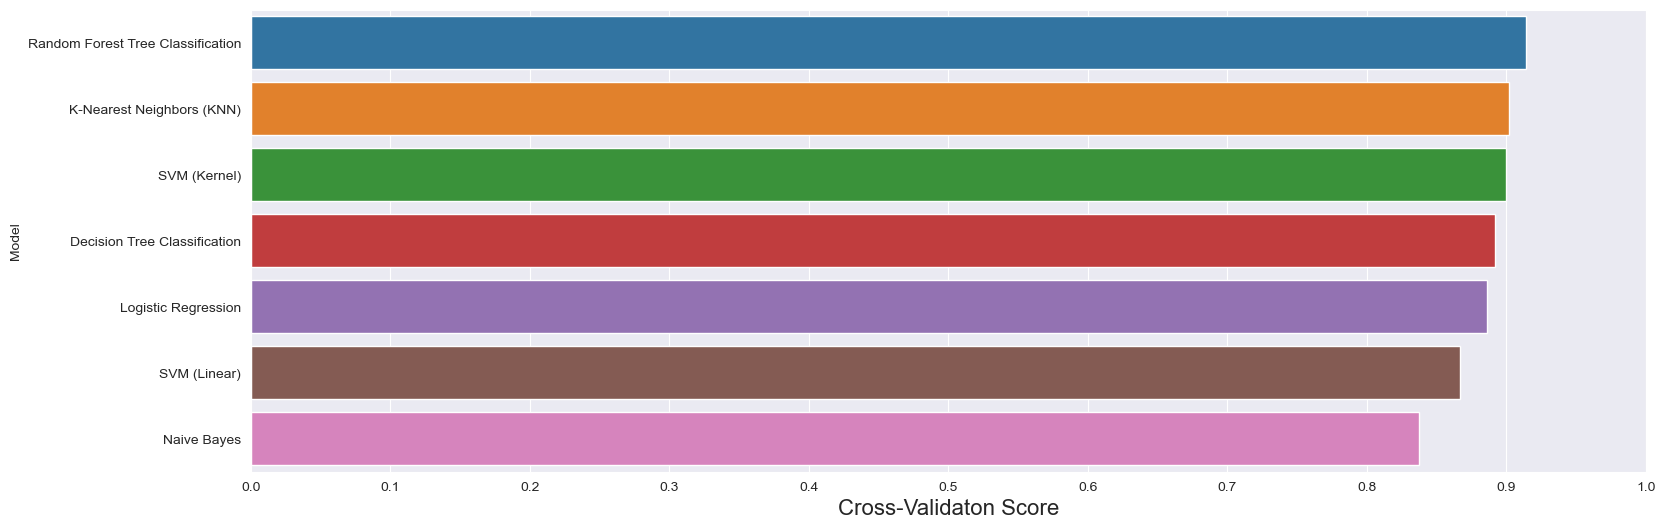

In [73]:
f, axe = plt.subplots(1,1, figsize=(18,6))

predict.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)

sns.barplot(x='Cross-Validation', y='Model', data = predict, ax = axe)
#axes[0].set(xlabel='Region', ylabel='Charges')
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)
axe.set_xticks(np.arange(0, 1.1, 0.1))
plt.show()

훈련 데이터의 정확도, 검증 데이터의 정확도가 높은 것부터 순서대로 시각화하여 나타냄

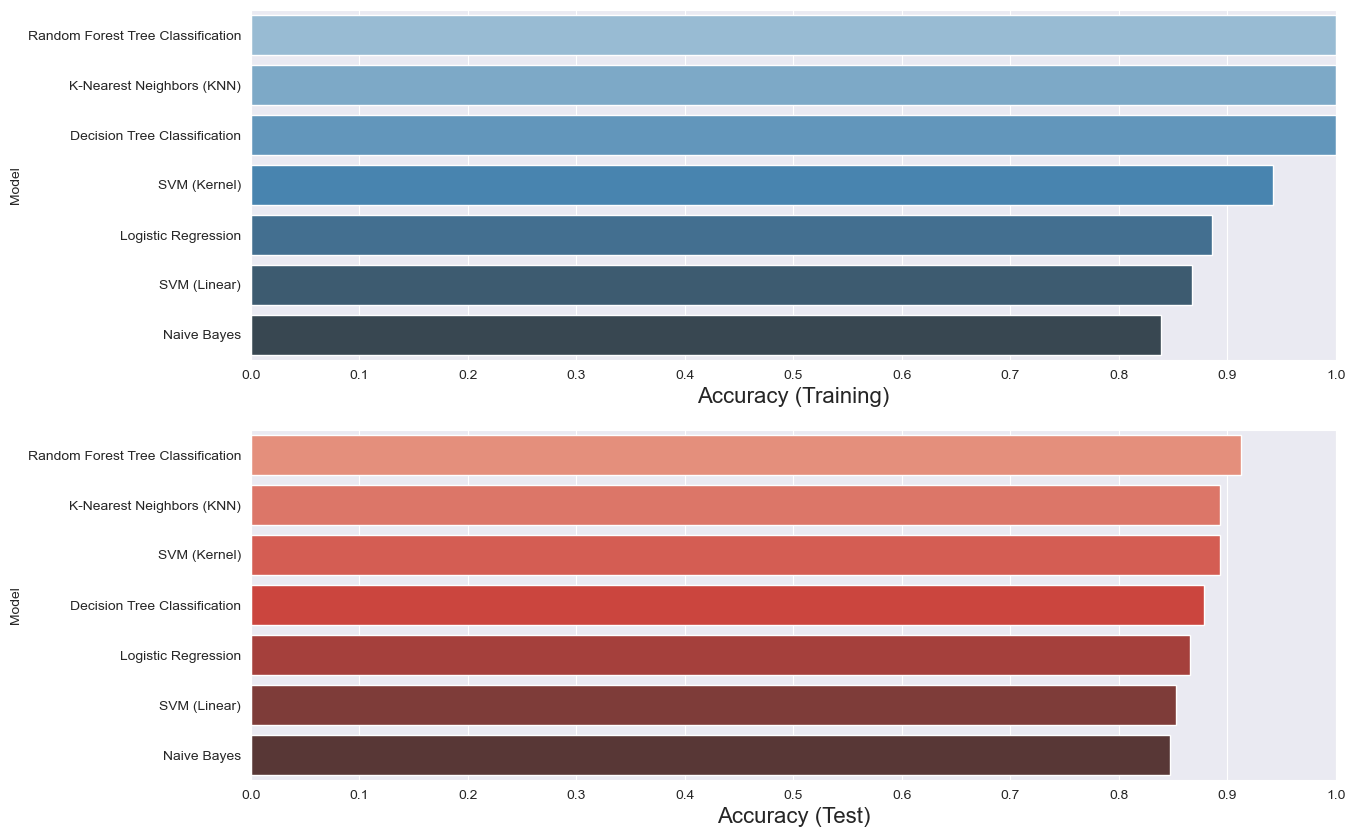

In [74]:
f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['Accuracy(training)'], ascending=False, inplace=True)

sns.barplot(x='Accuracy(training)', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('Accuracy (Training)', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)
axes[0].set_xticks(np.arange(0, 1.1, 0.1))

predict.sort_values(by=['Accuracy(test)'], ascending=False, inplace=True)

sns.barplot(x='Accuracy(test)', y='Model', data = predict, palette='Reds_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('Accuracy (Test)', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)
axes[1].set_xticks(np.arange(0, 1.1, 0.1))

plt.show()

테스트 데이터에 대한 예측의 잘못된 관찰 수(FP+FN)가 높은 것부터 시각화하여 나타냄

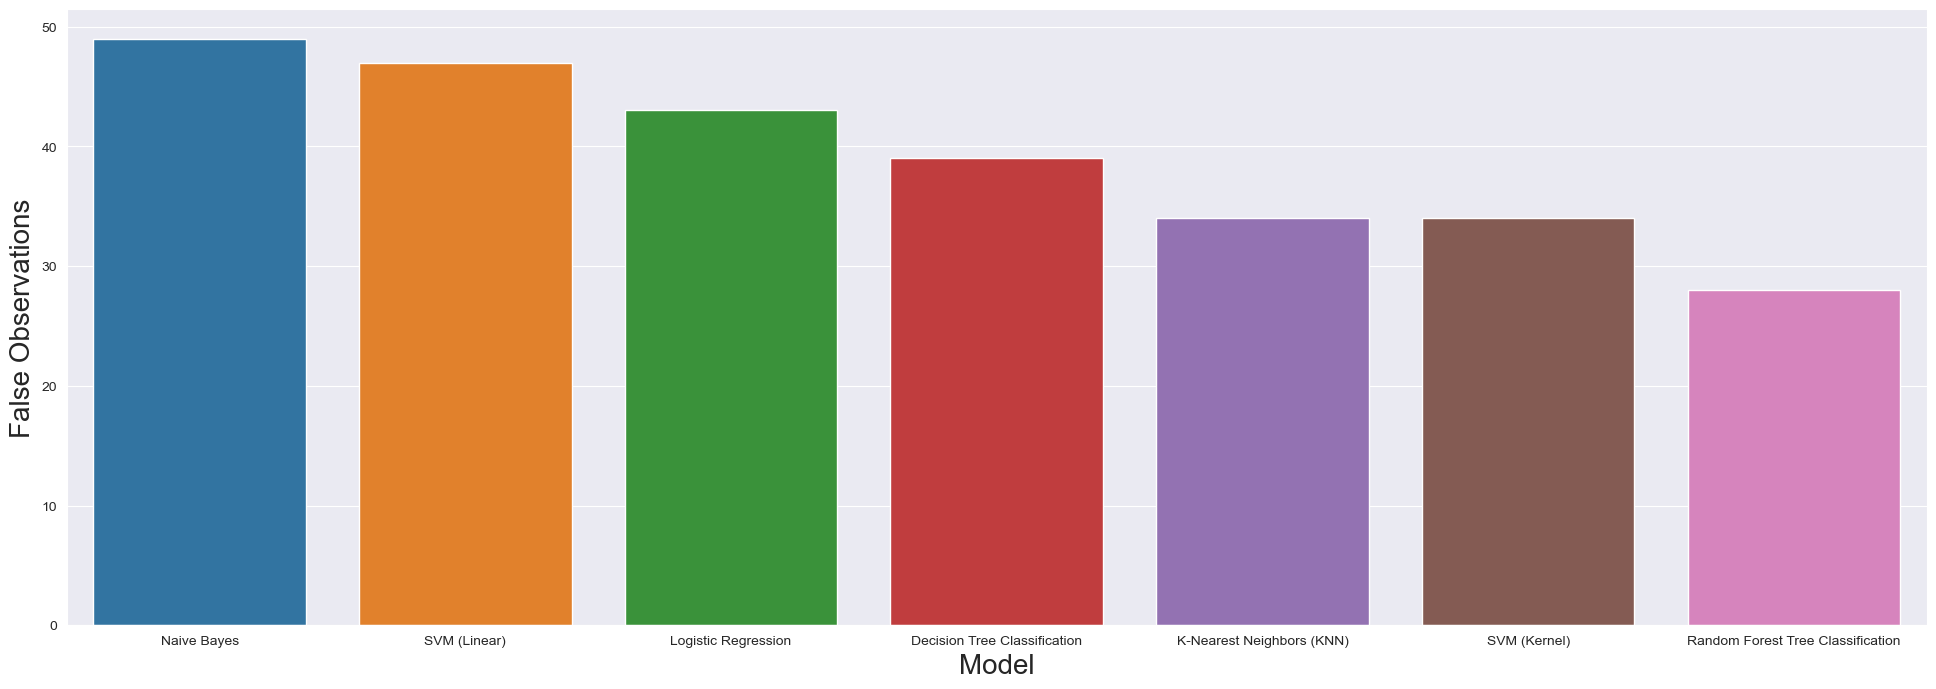

In [75]:
predict.sort_values(by=(['Accuracy(test)']), ascending=True, inplace=True)

f, axe = plt.subplots(1,1, figsize=(24,8))
sns.barplot(x = predict['Model'], y=predict['False Positive'] + predict['False Negative'], ax = axe)
axe.set_xlabel('Model', size=20)
axe.set_ylabel('False Observations', size=20)

plt.show()

## 7. Conclusion

레드 와인 품질 데이터세트를 7가지 분류 모델을 사용하여 나타냈다.